# Clustering
   
**Clustering with K-means**   

Now, the idea is to find some type of clustering to see if there is any pattern in the data that might provide some insigths.  

First, prepare for the analysis. 
Then, define the amount of clusters by applying the elbow test.
Finally, apply k-means methods to find the clusters.   
Once we have the labels we have to analyze the results 


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib import cm
import countries as countries_utils
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [3]:
df = pd.read_csv("cleaned_data.csv", encoding="ISO-8859-1")

## Countries

First, let's find cluster among countries. 
- We can devide the date column into year and month, those would be predictors for the model.   
- We would need to rename the countries to match with the world data. 
- Drop columns that are not necessary 

In [4]:
df['sales'] = df['Quantity']*df['UnitPrice']

# create year, month columns from the date 
df_aux = df.copy()
df_aux['year'] = pd.to_datetime(df_aux['InvoiceDate']).dt.strftime('%Y')
df_aux['month'] = pd.to_datetime(df_aux['InvoiceDate']).dt.strftime('%m')

countries_utils.update_values(df_aux, 'Country', ['USA', 'RSA', 'Czech Republic', 'EIRE'],
                             ['United States of America', 'South Africa', 'Czechia', 'Ireland'])

#drop unnecessary columns
df_aux.drop(['Description','InvoiceNo','InvoiceDate','UnitPrice','CustomerID'], axis=1, inplace=True)

#group by some columns and take the sum 
df_aux = df_aux.groupby(['StockCode','year','month', 'Country']).sum().reset_index()

# transform StockCode to integers
df_aux['StockCode'] = df_aux['StockCode'].astype('category').cat.codes
df_aux

,StockCode,year,month,Country,Quantity,cancelled,sales
0,0,2010,12,France,96,0,81.60
1,0,2010,12,Ireland,12,0,10.20
2,0,2010,12,United Kingdom,116,0,98.60
3,0,2011,01,France,156,0,132.60
4,0,2011,01,Germany,1,0,0.85
...,...,...,...,...,...,...,...
62470,3683,2011,12,Greece,3,0,135.00
62471,3683,2011,12,Norway,1,0,40.00
62472,3683,2011,12,Portugal,14,0,392.00
62473,3683,2011,12,Spain,1,0,28.00


Since we saw that United Kingdom is an outlier, we are going to study clusters without United Kingdom.
It is necessary to scale the data that is going to be input for the model. 

In [5]:
df_aux_1 = df_aux[df_aux['Country']!='United Kingdom'].copy()

x = df_aux_1.drop(['Country'],axis=1)
x = scale(x)

In order to find the optimal number of clusters, we can perform the elbow test. 

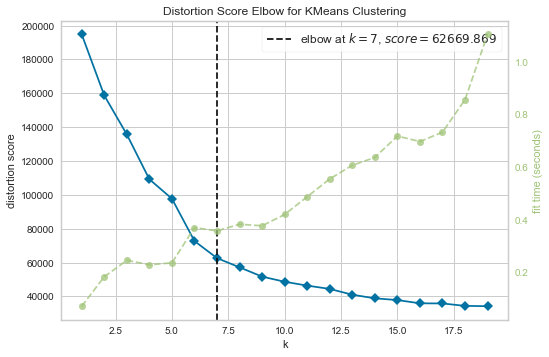

7


In [6]:
def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    visualizer = KElbowVisualizer(km, k=range(1, max_clusters))
    visualizer.fit(df)
    visualizer.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee

n_clusters = elbow_test(x, 10, 20, 300)
print(n_clusters)

Now that we have the optimal number of clusters, we can perform the model. 

In [7]:
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
df_aux_1['cluster'] = km.labels_

In order to visualize the results, we can plot the clusters into the map to see if there is a relationship with the countries. 

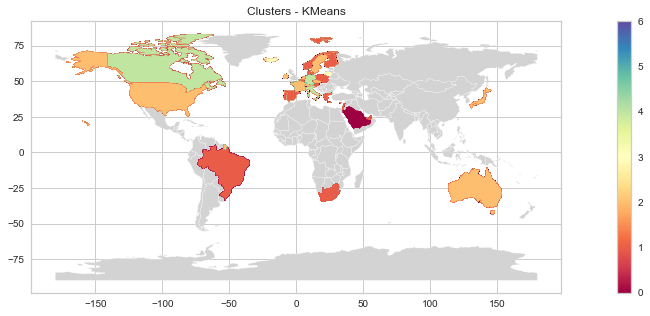

In [8]:
countries_utils.plot(df_aux_1, 'Clusters - KMeans', 'Country', 'cluster', True)

We can plot a scatter plot for two of the variables and see how the relationship between them has influence in the division of the clusters

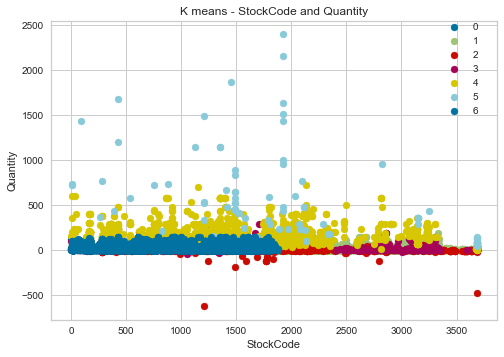

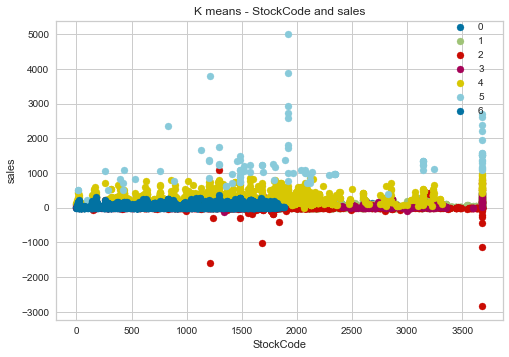

In [9]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
    
    ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()

draw_scatter(df_aux_1, 'StockCode', 'Quantity', 'cluster', n_clusters, 'K means - StockCode and Quantity')
draw_scatter(df_aux_1, 'StockCode', 'sales', 'cluster', n_clusters, 'K means - StockCode and sales')

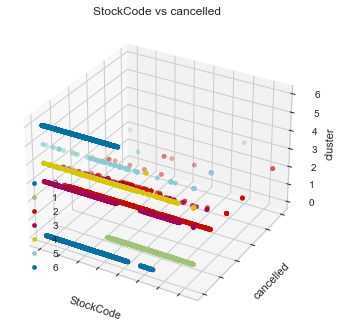

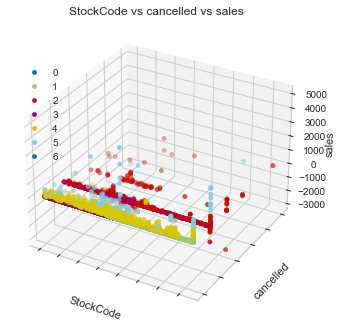

In [10]:
def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'cluster', 'cluster', n_clusters, 'StockCode vs cancelled')
create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'sales', 'cluster', n_clusters, 'StockCode vs cancelled vs sales')


## Customers

We can see how the customers are grouped according to their purchases.

In [11]:
#see who bought more for each product 
products = df[['StockCode', 'CustomerID', 'sales']].groupby(['StockCode', 'CustomerID']).count().reset_index()

# for each product keep top 10 sales
products_df = pd.DataFrame()
for p in products['StockCode'].unique():
    p_df = products[products['StockCode']==p].sort_values('sales', ascending=False).reset_index()
    p_df = p_df[0:10]
    products_df = products_df.append(p_df)

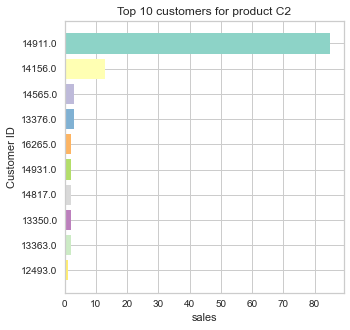

In [12]:
def plot_sales_per_customer(df, stockCode):
    stock_product = df[df['StockCode']==stockCode]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.invert_yaxis()
    colors = cm.get_cmap('Set3', stock_product.shape[0]).colors
    ax.barh(y=stock_product.index, width='sales', data=stock_product, color=colors)
    ax.set_yticks(range(0,10))
    ax.set_yticklabels(stock_product['CustomerID'].tolist())
    ax.set_ylabel('Customer ID')        
    ax.set_xlabel('sales')      
    ax.set_title("Top 10 customers for product " + stockCode)    
    plt.show()

plot_sales_per_customer(products_df, 'C2')

Keep the relevant information for each customer:
- total amount of purchases
- start date
- how many different products the customer bought
- total money spent
- last date purchase

In [13]:
#total amount of purchases
customers = df[df['cancelled']==0][['InvoiceNo','CustomerID']]
customers = customers.groupby(['CustomerID']).count().reset_index()
customers.rename(columns={'InvoiceNo':'total_purchases'}, inplace=True)

In [14]:
#start date
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).min().reset_index()
aux['InvoiceDate'] = pd.to_datetime(aux['InvoiceDate'])
aux['start_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['start_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['start_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['start_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID          0
total_purchases    33
start_year          0
start_month         0
start_day           0
start_hour          0
dtype: int64


In [15]:
#how many different products the customer bought
aux = df[['CustomerID','StockCode']].groupby(['CustomerID']).count().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)

In [16]:
#total money spent
aux = df.copy()
aux['spent'] = aux['Quantity']*aux['UnitPrice']
aux = aux[['CustomerID','spent']].groupby(['CustomerID']).sum().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)
customers['spent'] = customers['spent'].apply(lambda x: x if x>0 else 0)

In [17]:
#last date purchase
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).max().reset_index()
aux['InvoiceDate'] = pd.to_datetime(aux['InvoiceDate'])
aux['last_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['last_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['last_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['last_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID         0
total_purchases    0
start_year         0
start_month        0
start_day          0
start_hour         0
Products           0
spent              0
last_year          0
last_month         0
last_day           0
last_hour          0
dtype: int64


In [18]:
customers.columns

Index(['CustomerID', 'total_purchases', 'start_year', 'start_month',
       'start_day', 'start_hour', 'Products', 'spent', 'last_year',
       'last_month', 'last_day', 'last_hour'],
      dtype='object')

So now, we can apply k-means over this information and see how the customers are grouped 

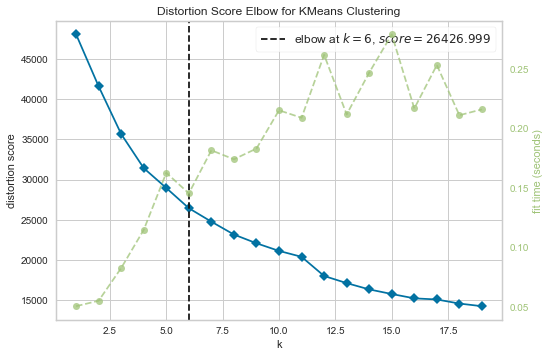

number of clusters: 6


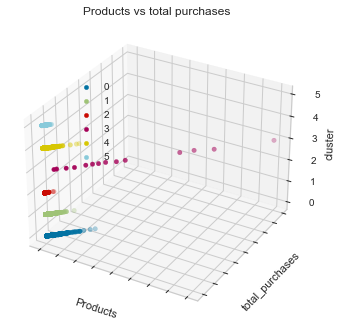

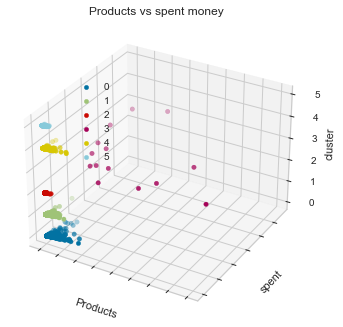

In [19]:
##apply k-means 
x = customers.drop(['CustomerID'],axis=1)
x = scale(x)
n_clusters = elbow_test(x, 10, 20, 300)
print('number of clusters:',n_clusters)
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
customers['cluster'] = km.labels_

#clients who made similar amount of purchases, buy similar products
create_3d_scatter(customers, 'Products', 'total_purchases', 'cluster', 'cluster', n_clusters, 'Products vs total purchases')

#while cluster 3 is more spread, generally the clients buy the same kind of products. Cluster 3 is the only one that has clients who spent more money 
create_3d_scatter(customers, 'Products', 'spent', 'cluster', 'cluster', n_clusters, 'Products vs spent money')

## Products

We can also see how the products are grouped considering the description.

In [20]:
#check codes that contain only letters
codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in codes:
    print("{:} : {}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST : POSTAGE
D : Discount
C2 : CARRIAGE
M : Manual
BANK CHARGES : Bank Charges
PADS : PADS TO MATCH ALL CUSHIONS
DOT : DOTCOM POSTAGE
CRUK : CRUK Commission


See the frequency of the words, we see this in a bar plot, and also plot the words into the space, setting with different sizes the words to represent its frequency. 

<AxesSubplot:xlabel='Word'>

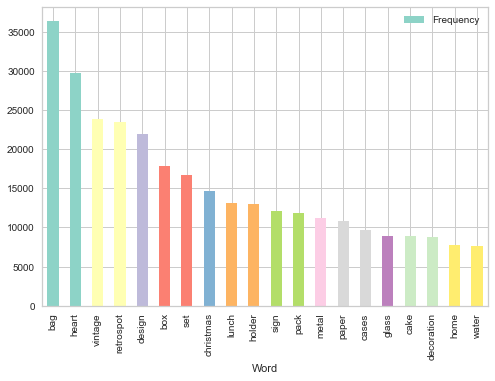

In [21]:
df['Description'] = df['Description'].str.lower()
a = df['Description'].str.cat(sep=" ")
words = nltk.tokenize.word_tokenize(a)
words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2]=='NN'] 
word_dist = nltk.FreqDist(words)
words = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency'])
words.sort_values(by='Frequency', ascending=False, inplace=True)
colors = cm.get_cmap('Set3', 20).colors
words[['Word','Frequency']].head(20).plot.bar(x='Word', y='Frequency', rot=90, color=colors)

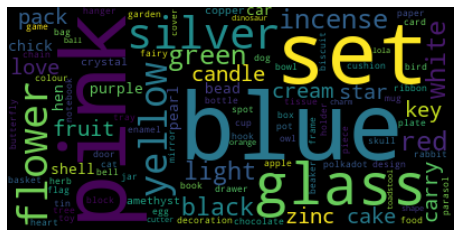

In [22]:
def generate_plot(ax, text, max_words=1000):
    wordcloud = WordCloud(max_words=max_words).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    return ax
    
text = " ".join(word for word in word_dist)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = generate_plot(ax, text, 100)
plt.show()

In order to execute the model, we can take a sample of the whole data and then run the model. 

In [23]:
df_sample = df['Description'].sample(frac=0.5, random_state=1).reset_index()
df_sample.head()

,index,Description
0,333303,love garland painted zinc
1,310607,monsters stencil craft
2,136133,12 pencils tall tube posy
3,22061,ladies & gentlemen metal sign
4,163593,childrens cutlery spaceboy


In [24]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=1000)
X = vectorizer.fit_transform(df_sample['Description'])

In [25]:
n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_model.fit(X)

KMeans(n_clusters=5, random_state=0)

Top 20 terms per cluster


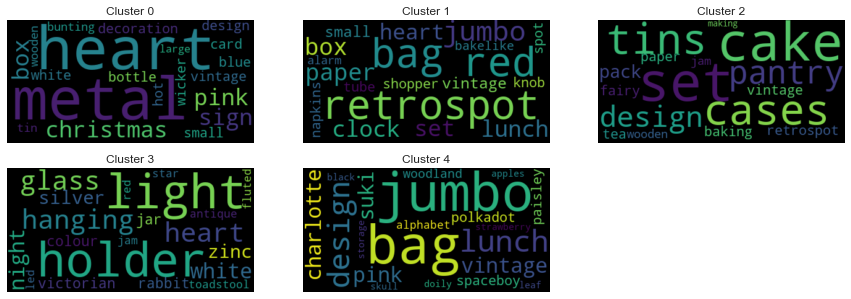

In [26]:
# get the clusters centers and order them 
# .argsort()[:, ::-1] line converts each centroid into a sorted
# list of the columns most relevant words 
top_n = 20
print("Top {} terms per cluster".format(top_n))
centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
feature_names = vectorizer.get_feature_names()
n = int(n_clusters/2) +1
fig, axs = plt.subplots(2, n, figsize=(15,5))
x = 0
y = 0
terms_vectorize = np.vectorize(lambda x: feature_names[x])
for i in range(n_clusters):
    text = " ".join(word for word in terms_vectorize(centroids[i, :top_n]))
    axs[x,y] = generate_plot(axs[x,y], text, 100)
    axs[x,y].set_title("Cluster " + str(i))
    y_aux = (y+1)%n
    if (y_aux < y):
        x = (x+1)%2
    y = y_aux

for ax in axs:
    for d in ax:
        d.axis("off")
plt.show()    

In [27]:
print("Find cluster for product ", df['Description'][0])
prediction = kmeans_model.predict(vectorizer.transform([df['Description'][0]]))
print('Assigned cluster ', prediction)

Find cluster for product  white hanging heart t-light holder
Assigned cluster  [3]
